In [1]:
import sys
sys.path.insert(1, '../Source_Code')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import importlib
import pandas as pd
import seaborn
from IPython.display import Image
import matplotlib.pyplot as plt

import Transformer as tnsf
import preprocess as ad

import copy
from matplotlib.colors import LogNorm
np.set_printoptions(threshold=sys.maxsize)

importlib.reload(ad)
importlib.reload(tnsf)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cuda"
print(device)

cuda


In [2]:
def test_generate(name, window_size=10):
    hdfs = set()
    # hdfs = []
    with open( name, 'r') as f:
        for ln in f.readlines():
            ln = list(map(lambda n: n, map(int, ln.strip().split())))
#             ln = ln + [0] * (window_size + 1 - len(ln))
            hdfs.add(tuple(ln))
            # hdfs.append(tuple(ln))
    print('Number of sessions({}): {}'.format(name, len(hdfs)))
    return hdfs

In [3]:
importlib.reload(ad)

<module 'preprocess' from '../Source_Code/preprocess.py'>

In [4]:
def create_mat(dataloader, model, layers, heads, file, enc =True, dec = False):
    
    enc_att = np.zeros((449,449))
    enc_tp_att = np.zeros((449,449))
    enc_fn_att = np.zeros((449,449))
    
    if dec:
        dec_att = np.zeros((449,449))
        dec_tp_att = np.zeros((449,449))
        dec_fn_att = np.zeros((449,449))
    
    src_mask = Variable(torch.ones(1, 1, window_size + 1)).to(device)
    bos = torch.ones((1, ),dtype = int).to(device)
    
    print("********** ********** ********** ********** **********")
    print("      ********** FIRST INPUT SEQUENCE ********** ")
    print("********** ********** ********** ********** **********")
    print("\n")
    sequence_cnt = 10
    anomaly_timeline = []
    line_number = 1
    for line in dataloader:
        if line_number%25==0:
            print("Current Sequence Number:",line_number)
        else:
            pass
        line_number += 1
        for i in range(len(line) - window_size):
            seq = line[i:i + window_size]
            
            #for predicting 10
            label = line[i+window_size:(i+window_size)+window_size]
            
            #for predicting only 1
            ###label = line[i+window_size:(i+window_size)+1]
            ###print("Sequence: {}".format(seq))
            ###ad.backtrace(seq, "linux.log", "Spell")
            

            t1 = torch.cat((bos, torch.tensor(seq, dtype = torch.int).to(device))).unsqueeze(0)
            t2 = torch.tensor(label, dtype = torch.int).to(device).unsqueeze(0)

            src = Variable(t1, requires_grad =False)
            tgt = Variable(t2, requires_grad =False)

            print("---------- ---------- ---------- ---------- ----------")
            print("Input Sequence: {}".format(seq))
            print("Label: {}".format(label))
            print("\n")

#             print("~~~~~~~~~~ ATTENTION WEIGHTS ON GREEDY DECODE ~~~~~~~~~~")
#             print("\n")
            ###tgt_pred = tnsf.predict(model, src, src_mask, tgt, max_len = len(tgt)+1, start_symbol = 1, g = 10)
            ###tgt_pred = tnsf.greedy_decode(model, src, src_mask, tgt, len(label)+1, 1, True, g=10, halt = True, layers = layers, heads = heads)
            tgt_pred, candidates = tnsf.greedy_decode(model, src, src_mask, tgt, 2, 1, True, g=10, halt = True, layers = layers, heads = heads)

            # List for every deteected anomaly
            if tgt_pred.cpu().detach().numpy() in candidates.cpu().detach().numpy():
                anomaly_timeline.append(0)
            else:
                anomaly_timeline.append(1)
                
            ###print("---------- ---------- ---------- ---------- ----------")
            ###print("Input Sequence: {}".format(seq))
            ###print("Label: {}".format(label))
            ###print("Pred: {}".format(tgt_pred[0][0]))

            print("\n")
            print("~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~")
            ad.backtrace(seq, "linux.log", "Spell")
            print("\n")
            print("~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~")
            ad.backtrace(label[:1], "linux.log", "Spell") 
            print("\n")
            print("~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~")
            ###ad.backtrace(tuple(tgt_pred.cpu().detach().numpy()[0]) , "linux.log", "Spell")
            ad.backtrace(tuple(np.flip(candidates.cpu().detach().numpy()[6:])) , "linux.log", "Spell")
            print("\n")
            
            enc_weights = 0
            
            for layer in range(layers):
                for h in range(heads):
                    ###print("Layer:{} , Head: {}".format(layer,h))
                    enc_weights += model.encoder.layers[layer].self_attn.attn[0, h].data[:len(label), 1:len(seq)+1][0]
                    ###print("~~~~~~~~~~ ENCODER ATTENTION WEIGHTS ~~~~~~~~~~")
                    ###print(enc_weights)
                    ###print("\n")
                    
            if dec:
                dec_weights = 0
                for layer in range(layers):
                    for h in range(heads):
                        ###print("Decoder Layer:{} , Head: {}".format(layer,h))                    
                        dec_weights += model.decoder.layers[layer].self_attn.attn[0, h].data[:len(label), :len(seq)][0]
                        ###if you are predicting 10 use the code below
                        ###dec_weights += model.decoder.layers[layer].self_attn.attn[0, h].data[:len(label), :len(seq)]
                        ###print("~~~~~~~~~~ DECODER ATTENTION WEIGHTS ~~~~~~~~~~")
                        ###print(dec_weights)
                        ###print("\n")
            
            print("########## END OF INFO FOR LOG SEQUENCE {} ##########".format(sequence_cnt))
            print("\n")
            print("\n")
            print("\n")

            sequence_cnt += 1
            
            print("********** ********** ********** ********** **********")
            print("     ********** INPUT SEQUENCE {} - {} **********".format(sequence_cnt-9,sequence_cnt))
            print("********** ********** ********** ********** **********")
            print("\n")
            
            ###print(label[0],tgt_pred.cpu().detach().numpy())
            ###print(label[0] in tgt_pred.cpu().detach().numpy())
            ###if label[0] not in tgt_pred.cpu().detach().numpy():
            ###    print(label[0],tgt_pred)
            ###else:
            ###    pass
            
            for i in range(len(tgt_pred)):
#             uncomment if you are using 10 predictions instead of 1
                for j in range(len(tgt_pred)):
                        enc_att[seq[i],label[j]] += enc_weights[i]  
#                 enc_att[seq[i], label[0]] += enc_weights[i]

            
            if -1 in tgt_pred:
                for i in range(len(tgt_pred)):
                #uncomment if you are using 10 predictions instead of 1
                    for j in range(len(tgt_pred)):
                        enc_tp_att[seq[i],label[j]] += enc_weights[i]
#                     enc_tp_att[seq[i],label[0]] += enc_weights[i]
            else:
                for i in range(len(tgt_pred)):
                #uncomment if you are using 10 predictions instead of 1
                    for j in range(len(tgt_pred)):
                        enc_fn_att[seq[i],label[j]] += enc_weights[i]    
#                     enc_fn_att[seq[i], label[0]] += enc_weights[i]
            
            if dec:
                for i in range(len(tgt_pred)):
                    for j in range(len(tgt_pred)):
                        dec_att[seq[i], label[j]] += dec_weights[i]

                if -1 in tgt_pred:
#                    print("halt")
                    for i in range(len(tgt_pred)):
                        for j in range(len(tgt_pred)):
                            dec_tp_att[seq[i],label[j]] += dec_weights[i]
                else:
                    for i in range(len(tgt_pred)):
                        for j in range(len(tgt_pred)):
                            dec_fn_att[seq[i], label[j]] += dec_weights[i]    
            

#     with open("Attention-Based_Weights/all_" + file + '_attention.npy', 'wb') as f:
#         np.save(f, enc_att)
                        
#     with open("Attention-Based_Weights/tp_" + file + '_attention.npy', 'wb') as f:
#         np.save(f, enc_tp_att)
        
#     with open("Attention-Based_Weights/fn_" + file + '_attention.npy', 'wb') as f:
#         np.save(f, enc_fn_att)        
    
    enc_att_normalized =(enc_att-np.min(enc_tp_att))/(np.max(enc_att)-np.min(enc_att))
    enc_tp_att_normalized =(enc_tp_att-np.min(enc_tp_att))/(np.max(enc_tp_att)-np.min(enc_tp_att))
    enc_fn_att_normalized =(enc_fn_att-np.min(enc_fn_att))/(np.max(enc_fn_att)-np.min(enc_fn_att))
#     print(enc_fn_att_normalized[enc_fn_att_normalized>0])
    if dec:
        dec_att_normalized =(dec_att-np.min(dec_tp_att))/(np.max(dec_att)-np.min(dec_att))
        dec_tp_att_normalized =(dec_tp_att-np.min(dec_tp_att))/(np.max(dec_tp_att)-np.min(dec_tp_att))
        dec_fn_att_normalized =(dec_fn_att-np.min(dec_fn_att))/(np.max(dec_fn_att)-np.min(dec_fn_att))

#     with open("Attention-Based_Weights/all_" + file + '_normalized_attention.npy', 'wb') as f:
#             np.save(f, enc_att_normalized)  
#     with open("Attention-Based_Weights/tp_" + file + '_normalized_attention.npy', 'wb') as f:
#             np.save(f, enc_tp_att_normalized)  
#     with open("Attention-Based_Weights/fn_" + file + '_normalized_attention.npy', 'wb') as f:
#             np.save(f, enc_fn_att_normalized)              

    # Plot Anomaly Detection Timeline
    fig = plt.figure(figsize = (15, 5))
    x = range(11,len(anomaly_timeline)+11)
    plt.xlabel("Log Timeline", fontsize=14)
    plt.ylabel("Anomaly = 1, Normal =0", fontsize=14)
    plt.title("Anomaly Detection Timelline", fontsize=14)
    plt.bar(x, anomaly_timeline, color = "blue")
    plt.xlim([11, len(anomaly_timeline)+11])
    #plt.setp(axs[1], yscale = 'log', xlabel="Log Key (Input Sequences)")
    plt.tight_layout()
    # plt.savefig('GonnaCry_bar_all.png')
    plt.show()        
            
#     return (enc_att_normalized, enc_tp_att_normalized, enc_fn_att_normalized), (dec_att_normalized, dec_tp_att_normalized, dec_fn_att_normalized)
    return (enc_att_normalized, enc_tp_att_normalized, enc_fn_att_normalized)

In [5]:
test_abnormal_loader = test_generate("../CTDD_Dataset/Sample_Cyber_Threat_Log_Keys/jy-ntp-ddos-amplification-atk-tool-t1498")

Number of sessions(../CTDD_Dataset/Sample_Cyber_Threat_Log_Keys/jy-ntp-ddos-amplification-atk-tool-t1498): 1


In [6]:
model = torch.load("../Saved_Models/global_models_practicum.pt")

In [7]:
# Model information
layers = 1
heads = 1
WINDOW_SIZE = 10
window_size = 10
importlib.reload(ad)
importlib.reload(tnsf)

<module 'Transformer' from '../Source_Code/Transformer.py'>

********** ********** ********** ********** **********
      ********** FIRST INPUT SEQUENCE ********** 
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (418, 258, 259, 224, 260, 260, 260, 260, 260, 260)
Label: (260, 260, 263, 264, 264, 264, 164, 265, 266, 267)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([  8,  44,  11, 263,  17, 260,   5,   7,  19, 264], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0542 0.0558 0.0658 0.0676 0.0830 0.0982 0.0997 0.1492 0.1554 0.1711], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2025 0.2409 0.0478 0.0000 0.4194 1.0000 0.6522 0.4500 0.4410 0.3403]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
418 204    Starting Docker Application Container Engine...
258 159    time <*> <*>"" level info msg ""Starting up""
259 16

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
263 161    time <*> <*>"" level info msg ""[graphdriver] ...
264 95    time <*> <*>"" level warning msg ""Your kernel...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
264 95    time <*> <*>"" level warning msg ""Your kernel...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
5 8    ens3 DHCP lease lost
264 95    time <*> <*>"" level warning msg ""Your kernel...
17 1    Could not set hostname Method call timed out
164 107    time <*> <*>"" level info msg ""Loading contai...


########## END OF INFO FOR LOG SEQUENCE 14

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([169,  71,   4,  79, 264, 266, 129, 267,  15, 269], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0589 0.0598 0.0627 0.0637 0.0647 0.0758 0.0762 0.0869 0.2026 0.2488], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.3762 0.2930 0.3428 0.5575 0.0000 0.0000 0.3268 1.0000 0.1664 0.8063]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
263 161    time <*> <*>"" level info msg ""[graphdriver] ...
264 95    time <*> <*>"" level warning msg ""Your kernel...
264 95    time <*> <*>"" level warning msg ""Your kernel...
264 95    time <*> <*>"" level warning msg ""Your kernel...
164 107    time <*> <*>"" level info msg ""Lo

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 17, 271, 171, 168,  44,   7,  19,   3,   5, 164], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0654 0.0656 0.0659 0.0728 0.0736 0.0782 0.0801 0.1157 0.1518 0.2309], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0690 0.0000 1.0000 0.0707 0.3730 0.6463 0.3013 0.1400 0.7293 0.2224]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
264 95    time <*> <*>"" level warning msg ""Your kernel...
264 95    time <*> <*>"" level warning msg ""Your kernel...
164 107    time <*> <*>"" level info msg ""Loading contai...
265 151    <*> <*> Bridge firewalling registered
266 150    <*> <*> Initializing XFRM netlink socket
267 145    <*> <*> Netfilter messages via NETLINK v0.<*>.
268 144    <*> <*> ctnetlink v0.<*> registering with nfne...
269 125    link_config autonegotiation is unset or enable...
270 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 51, 175, 164,   5,  44,  17,   2, 172, 117,   3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0451 0.0501 0.0502 0.0679 0.0741 0.0827 0.1054 0.1060 0.2041 0.2144], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0809 0.0893 0.0582 0.0000 0.1643 1.0000 0.2333 0.1064 0.0634 0.1307]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
267 145    <*> <*> Netfilter messages via NETLINK v0.<*>.
268 144    <*> <*> ctnetlink v0.<*> registering with nfne...
269 125    link_config autonegotiation is unset or enable...
270 148    WARNING Unknown index <*> seen reloading inter...
271 143    <*> Link UP
164 107    time <*> <*>"" level info msg ""Loading contai...
168 131    time <*> <*>"" level info msg ""Docker daemon"...
169 133    time <*> <*>"" level info msg ""Daemon has com...
170 118    Started 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([  9, 204, 212, 400,   8,  10, 402,  77, 401,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0004 0.0005 0.0007 0.9965], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.8413 0.0000 0.3781 0.0934 0.0000 1.0000 0.3762 0.3809 0.4046 0.1550]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
164 107    time <*> <*>"" level info msg ""Loading contai...
168 131    time <*> <*>"" level info msg ""Docker daemon"...
169 133    time <*> <*>"" level info msg ""Daemon has com...
170 118    Started Docker Application Container Engine.
171 123    time <*> <*>"" level info msg ""API listen on ...
5 8    ens3 DHCP lease lost
6 6    [system] Activating via systemd service name '...
9 12    Started ntp-systemd-netif.service.
8 2    Starting <*> Service...
10 7   

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([174,   9,  54,  81,  13,  11,  17,  12,  15,   8], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0330 0.0363 0.0377 0.0458 0.0496 0.0507 0.0521 0.0625 0.2277 0.4048], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2035 0.0926 0.0628 0.0861 0.1149 0.0000 0.1569 0.1916 1.0000 0.8078]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
5 8    ens3 DHCP lease lost
6 6    [system] Activating via systemd service name '...
9 12    Started ntp-systemd-netif.service.
8 2    Starting <*> Service...
10 7    ens3 DHCPv4 address <*>/<*> via <*>
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Serv

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4



########## END OF INFO FOR LOG SEQUENCE 43 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 35 - 44 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (11, 9, 420, 421, 423, 423, 423, 423, 423, 423)
Label: (423, 423, 423, 423, 423, 423, 422, 423, 423, 423)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([14, 19,  7, 44, 77, 26, 11,  5,  8, 17], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0236 0.0272 0.0279 0.0354 0.0487 0.0839 0.0963 0.1577 0.2399 0.2594], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2184 0.0389 0.0480 0.2443 0.4259 0.9066 1.0000 0.0000 0.5517 0.8319]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

423 109    <*> local addr <*> -> <null>


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
8 2    Starting <*> Service...
17 1    Could not set hostname Method call timed out
11 0    ens3 Configured
7 15    Network configuration changed trying to establ...


########## END OF INFO FOR LOG SEQUENCE 48 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 40 - 49 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (423, 423, 423, 423, 423, 423, 423, 423, 423, 423)
Label: (423, 422, 423, 423, 423, 423, 423, 8, 12, 13)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([67,  7, 14, 26, 44, 15,  5, 11, 17,  8], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0264 0.0265 0.0378 0.0385 0.0408 0.0682 0.0905 0.0946 0.1215 0.4552], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
423 109    <*> local addr <*> -> <null>


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
17 1    Could not set hostname Method call timed out
5 8    ens3 DHCP lease lost
8 2    Starting <*> Service...
26 13    Low random number entropy available <*>


########## END OF INFO FOR LOG SEQUENCE 53 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 45 - 54 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (423, 423,

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 26,  16,  21, 113,   9,  18,  44,  10,  14,  13], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0003 0.0004 0.0004 0.0004 0.0004 0.0004 0.0005 0.0016 0.0024 0.9934], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2149 0.2037 0.2589 0.2249 0.4727 0.0000 0.5613 1.0000 0.1089 0.0000]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
8 2    Starting <*> Service...
12 9    systemd-hostnamed.service Failed to set up mou...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
13 10    systemd

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: Run

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([120,  19,  44,  10,   3,   4,  26,  11,   5,  17], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0270 0.0310 0.0325 0.0373 0.0387 0.0396 0.0806 0.1622 0.1806 0.3705], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.4670 0.0000 0.2963 0.1179 1.0000 0.3503 0.8300 0.1524 0.0836 0.2471]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
423 109    <*> local addr <*> -> <null>
8 2    Starting <*> Service...
12 9    systemd-hostnamed.service Failed to set up mou...
13 10    systemd-hostnamed.service Failed at step NAMES...
14 3    <*> Main process exited code <*

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([51, 40, 53,  5, 20, 77, 17,  3, 16,  4], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0218 0.0225 0.0226 0.0296 0.0326 0.0348 0.0603 0.0726 0.3307 0.3724], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0652 0.1989 0.0270 0.0581 0.1689 0.1069 0.0000 0.0000 0.5057 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
13 10    systemd-hostnamed.service Failed at step NAMES...
14 3    <*> Main process exited code <*> status <*>
15 4    <*> Failed with result 'exit-code'.
16 5    Failed to start <*>
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Ne

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 13,  10, 120,  36,  32,  22,  19,   5,  17,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0539 0.0576 0.0602 0.0679 0.0682 0.0688 0.0783 0.1188 0.1504 0.2761], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0113 0.1747 0.3222 1.0000 0.2396 0.2860 0.2348 0.1592 0.3005]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>
42

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packag

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 47,  62,  11,   3, 121,  19,  26,  17,  44,   5], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0073 0.0120 0.0129 0.0133 0.0166 0.0437 0.0527 0.1961 0.3072 0.3383], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1916 0.0000 0.3956 0.5874 0.5548 0.1691 0.2712 1.0000 0.2119 0.5381]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
3 25    Server returned error NXDOMA

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: Run

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 28,  97, 121,  22,  12,   8,  26,  44,  17,   5], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0253 0.0298 0.0363 0.0382 0.0465 0.0728 0.0804 0.0807 0.2208 0.3691], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0499 0.3173 0.0536 0.3386 0.7335 0.6613 1.0000 0.0895 0.0544]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
431 197    Listening on routing socket on fd #<*> for int...
3 25    Server returned error NXDOMAIN mitigating pote...
17 1    Could not set hostname Method call timed out
18 11    Could not set hostname Failed to activate serv...
44 21    [I <*>.<*> LabApp] <*>
419 170    TermSocket.open <*>
419 170    Te

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 19, 400,  95,  26,  20,  17,  13,   5,  10,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0174 0.0180 0.0186 0.0234 0.0235 0.0356 0.0387 0.0403 0.3873 0.3971], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.8033 0.4948 0.0000 0.2726 0.4764 1.0000 0.0000 0.3305 0.1634 0.4575]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
419 170    TermSocket.open <*>
419 170    TermSocket.open <*>
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 53,   9, 120,  16,   5,  54,  15,  17,   3,   4], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0299 0.0317 0.0328 0.0383 0.0412 0.0480 0.0504 0.0625 0.1633 0.5018], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0375 0.0381 0.0289 0.0116 0.0134 0.0000 0.0450 0.0845 0.1357 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Servic

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([199,  66,  13,  17,   5,  54,  20, 203,  36,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0325 0.0331 0.0423 0.0425 0.0499 0.0539 0.0691 0.0931 0.1047 0.4788], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0334 0.0000 0.1339 0.2474 1.0000 0.0000 0.8192 0.6237 0.3440 0.2616]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>
42

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([20, 38, 44, 19, 11, 26, 34,  5, 17,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0011 0.0018 0.0030 0.0044 0.0078 0.0201 0.0401 0.0642 0.0849 0.7725], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2970 1.0000 0.0000 0.1029 0.8052 0.8455 0.3790 0.1703 0.1146 0.0290]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error N

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([20, 19, 11,  4, 26, 34, 38, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0008 0.0009 0.0010 0.0015 0.0040 0.0043 0.0051 0.0383 0.0438 0.9002], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1715 0.1174 0.3918 0.3082 0.5173 0.7942 1.0000 0.0000 0.4498 0.3896]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
431 197    Listening on routing socket on fd #<*> for int...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    S

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([11, 38, 20, 18, 19, 34, 26,  5, 17,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0006 0.0009 0.0011 0.0011 0.0014 0.0039 0.0059 0.0217 0.0281 0.9354], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.4525 0.2255 0.3593 0.6560 0.4092 1.0000 0.8697 0.0000 0.4780 0.4142]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Serv

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([11, 58,  4, 20, 34, 38, 26, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0006 0.0007 0.0008 0.0010 0.0021 0.0023 0.0036 0.0107 0.0140 0.9641], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1789 0.2469 0.5808 0.6356 1.0000 0.7050 0.6899 0.8696 0.6980]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Serv

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([72, 49, 81, 19, 34, 26, 11,  3,  5, 17], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0060 0.0074 0.0096 0.0314 0.0432 0.0533 0.0825 0.1967 0.2134 0.3566], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1835 0.0000 0.2729 0.5219 0.2894 0.8582 1.0000 0.6213 0.6003 0.4215]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned err

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 27, 242,   3,  34,   9,  10,   7,  81,   8,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0280 0.0300 0.0329 0.0329 0.0365 0.0483 0.0623 0.0893 0.1452 0.4946], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0899 0.2630 0.3287 0.5109 0.9700 0.8568 0.4085 0.2748 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 38,  49,   4, 117,  26,   8,  17,   5,  34,   3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0054 0.0056 0.0073 0.0081 0.0117 0.0171 0.0619 0.0665 0.0759 0.7405], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1080 0.0507 0.0566 0.0926 0.1117 0.1354 0.0000 0.3116 0.1002 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
20 14    pcp CMD <*> -C
17 1    Could not set hostname Method call timed out
6 6    [system] Activating via systemd service name '...


########## END OF INFO FOR LOG SEQUENCE 137 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 129 - 138 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (441, 441, 442, 3, 443, 441, 441, 441, 441, 441)
Label: (441, 441, 441, 441, 441, 443, 441, 441, 441, 441)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 81,  26,  44, 117,   7,  17,   3,   8,   5,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0378 0.0379 0.0431 0.0478 0.0819 0.1067 0.1149 0.1550 0.1

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4


441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
6 6    [system] Activating via systemd service name '...
81 31    debug running <*> on /dev/sda<*>
78 34    macOS the wait is over. Learn how to install M...
49 51    <*> User Manager for UID <*>


########## END OF INFO FOR LOG SEQUENCE 142 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 134 - 143 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (441, 441, 441, 441, 441, 441, 441, 441, 441, 441)
L

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

Probabilities:  tf.Tensor([0.0340 0.0388 0.0402 0.0571 0.0617 0.0660 0.0697 0.1007 0.2449 0.2870], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0346 0.0000 0.0781 0.0628 0.0566 0.0713 1.0000 0.0000 0.0546 0.0441]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*>

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 41,   9,  35,  10,   3,  81, 404,   7,   8,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0069 0.0078 0.0085 0.0086 0.0097 0.0167 0.0176 0.0386 0.0697 0.8158], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1616 1.0000 0.4139 0.0000 0.4760 0.7823 0.3292 0.4320 0.4523 0.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([14, 72, 67, 19,  4, 26, 34,  5, 17,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0017 0.0017 0.0019 0.0045 0.0052 0.0090 0.0148 0.0548 0.0667 0.8398], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.3075 0.2000 0.3713 0.3499 0.4044 0.5537 0.6949 0.0000 1.0000 0.8578]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
3 25    Server returned error NXDOMAIN mitigating pote..

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 8, 36, 44, 81, 20,  5, 17, 34,  6,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0091 0.0092 0.0103 0.0166 0.0236 0.0480 0.0607 0.0637 0.1545 0.6043], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0475 0.0174 0.0285 0.0634 0.0000 0.0934 1.0000 0.0763 0.1643]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([117,  41,  11,  72,  17,   5,  81,  34,   6,   3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0302 0.0316 0.0325 0.0365 0.0646 0.0669 0.0776 0.1629 0.2145 0.2828], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1594 0.0000 0.4601 0.5772 1.0000 0.7990 0.8014 0.5533 0.2903]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>]

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([81, 77, 10, 34, 26,  3, 19, 17,  5,  6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0304 0.0376 0.0383 0.0387 0.0422 0.0492 0.0626 0.1549 0.1951 0.3509], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0614 0.0000 0.0612 0.0854 0.1400 0.0000 0.1397 0.1862 1.0000 0.2055]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([117,   6,  20,  49,   9,   7,  34,  81,   3,   8], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0700 0.0718 0.0753 0.0757 0.0777 0.0895 0.1021 0.1092 0.1642 0.1645], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0074 0.0000 0.2059 1.0000 0.2010 0.3504 0.1977 0.1537 0.0964 0.2921]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([87, 38,  4,  9, 19, 26, 34,  5, 17,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0054 0.0055 0.0060 0.0060 0.0199 0.0297 0.0794 0.1560 0.1893 0.5027], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1563 0.0000 0.2020 0.2565 0.3221 0.6491 0.9704 1.0000 0.0000 0.3796]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 16,  27,  72,   8,   3, 404,  10,  34,   7,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0117 0.0128 0.0129 0.0139 0.0212 0.0214 0.0232 0.0233 0.0423 0.8173], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1088 0.0000 0.0000 0.0000 0.0409 1.0000 0.2057 0.2025 0.1536 0.0647]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
3 25    Server returned error NXDOMAIN mitigating pote...
443 214  

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 5, 27, 72, 85, 18, 17,  3, 81, 34,  6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0350 0.0373 0.0425 0.0542 0.0548 0.0561 0.0711 0.1557 0.1746 0.3186], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [1.0000 0.0000 0.0399 0.3865 0.5148 0.1728 0.8867 0.2030 0.5514 0.9673]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([  8,  41,  49,  32, 404,   7,   3,  10,  81,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0304 0.0304 0.0337 0.0408 0.0412 0.0428 0.0439 0.0479 0.0747 0.6141], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0267 0.0919 0.1569 0.1595 0.1684 1.0000 0.1466 0.0933 0.1545]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([404,   9,   5,  17,  81,  34,  10,   8,   7,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0102 0.0120 0.0146 0.0154 0.0211 0.0243 0.0267 0.0344 0.0455 0.7960], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0986 1.0000 0.1370 0.3425 0.3289 0.6396 0.5257 0.3579 0.2096 0.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 44,  77,  19,   6, 117,  26,  34,  17,   5,   3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0043 0.0046 0.0063 0.0067 0.0070 0.0169 0.0672 0.0787 0.1029 0.7053], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0707 0.0000 0.1269 0.1644 0.1659 0.2707 0.2161 0.0785 0.1091 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4


     ********** INPUT SEQUENCE 203 - 212 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (441, 441, 3, 3, 443, 441, 441, 441, 441, 441)
Label: (441, 441, 441, 441, 441, 3, 3, 3, 3, 3)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 27,  17,   5,  10,   3,  34, 404,   7,   8,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0114 0.0200 0.0204 0.0257 0.0317 0.0321 0.0394 0.0429 0.1095 0.6670], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0657 0.0730 0.0399 0.0431 1.0000 0.0000 0.1927 0.2407 0.1033 0.0654]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
17 1    Could not set hostname Method call timed out
6 6    [system] Activating via systemd service name '...
5 8    ens3 DHCP lease lost
81 31    debug running <*> on /dev/sda<*>


########## END OF INFO FOR LOG SEQUENCE 216 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 208 - 217 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (441, 441, 441, 441, 441, 441, 441, 441, 441, 441)
Label: (3, 3, 3, 3, 3, 3, 3, 3, 443, 441)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 17,  10,  18, 404,   5,  81,   9,   7,   8,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0125 0.0131 0.0158 0.0206 0.0232 0.0244 0.0353 0.0554 0.0572 0.7425], shape=(10,), 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
5 8    ens3 DHCP lease lost
17 1    Could not set hostname Method call timed out
34 27    Started Daily apt <*> activities.


########## END OF INFO FOR LOG SEQUENCE 221 ##########






********** ********** ********** ********** **********
     ********** INPUT SEQUENCE 213 - 222 **********
********** ********** ********** ********** **********


---------- ---------- ---------- ---------- ----------
Input Sequence: (441, 441, 441, 441, 441, 3, 3, 3, 3, 3)
Label: (3, 3, 3, 443, 441, 441, 441, 441, 441, 441)


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
5 8    ens3 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 96,  72, 404,   5,  17,   7,  34,  81,   3,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0164 0.0166 0.0227 0.0341 0.0361 0.0369 0.0515 0.0541 0.0619 0.6696], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0413 0.0000 0.0296 0.0359 1.0000 0.0959 0.0866 0.0540 0.0309 0.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] aud

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([34, 81, 72,  9, 17,  5,  3,  7,  8,  6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0212 0.0224 0.0229 0.0230 0.0306 0.0313 0.0555 0.0708 0.2486 0.4737], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0007 0.2350 1.0000 0.2720 0.8337 0.4386 0.2478 0.1006 0.1113]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 27, 141,   8,  18,   7, 404,   5,  17,   3,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0139 0.0158 0.0165 0.0167 0.0259 0.0270 0.0316 0.0454 0.0810 0.7261], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0921 0.0640 0.0000 0.0974 0.3558 1.0000 0.2445 0.0979 0.1338 0.1407]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
443 214

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: Run

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([27, 72,  7,  5,  8, 17,  3, 34, 81,  6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0222 0.0263 0.0302 0.0407 0.0504 0.0581 0.0591 0.0620 0.0862 0.5649], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [1.0000 0.1306 0.2350 0.0000 0.4961 0.3967 0.4933 0.3784 0.4295 0.3002]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([49, 81, 77, 19,  4, 26,  5, 17, 34,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0019 0.0024 0.0025 0.0026 0.0047 0.0063 0.0222 0.0228 0.0312 0.9032], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.4961 0.0000 0.4247 1.0000 0.7437 0.0000 0.5877 0.2104 0.2739 0.2777]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...


../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([44, 19,  4, 20, 38, 26, 17,  5, 34,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0012 0.0015 0.0019 0.0019 0.0023 0.0034 0.0147 0.0185 0.0271 0.9275], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1392 0.0666 0.0594 0.1239 0.2310 0.1489 0.0000 0.0777 0.0827 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned e

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 20, 404,   9,  34,   5,   3,  17,   7,   8,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0306 0.0376 0.0466 0.0598 0.0715 0.0785 0.0843 0.0993 0.2243 0.2675], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0250 0.0670 0.0472 0.0396 1.0000 0.1504 0.1554 0.1849 0.1109 0.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] aud

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 17,   5, 404,  81,   9,  34,  10,   7,   8,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0144 0.0147 0.0159 0.0166 0.0194 0.0281 0.0371 0.0373 0.0454 0.7710], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0032 0.1379 0.0116 0.7060 0.2857 0.6327 0.3931 1.0000 0.0000 0.0081]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([195,   9,  47,  34,  19,   3,  44,  26,  17,   5], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0130 0.0208 0.0231 0.0368 0.0407 0.0597 0.0947 0.1033 0.2719 0.3360], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2746 0.1780 0.3455 0.0000 1.0000 0.3122 0.2057 0.2454 0.1937 0.2477]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
444 176

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([32,  4, 19, 47, 26, 44, 34, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0065 0.0076 0.0135 0.0224 0.0246 0.0330 0.0624 0.1471 0.1541 0.5288], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2089 0.2055 0.3941 0.3899 0.5514 0.5564 1.0000 0.6237 0.0000 0.7122]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packag

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([58, 47, 20, 19, 38, 26, 34, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0006 0.0007 0.0007 0.0008 0.0015 0.0019 0.0025 0.0120 0.0175 0.9619], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1200 0.0000 0.3653 0.4520 0.6258 0.7214 1.0000 0.7212 0.6098 0.2406]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote.

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 81, 202,   5,  15,   7,  17,  34,   6,   8,   3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0243 0.0313 0.0348 0.0359 0.0504 0.0576 0.0813 0.0993 0.1174 0.4676], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0840 0.0000 0.1292 0.0923 0.0703 0.1174 0.1367 1.0000 0.3089 0.2277]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 37,  26,  49,  81, 404,   5,  34,  17,   3,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0169 0.0178 0.0233 0.0256 0.0295 0.0547 0.0562 0.0918 0.0982 0.5860], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1797 1.0000 0.1624 0.4932 0.6934 0.5083 0.2379 0.2066 0.2587]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>]

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:4

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 72,  34,  18, 203,   3,  15,   5,   7,  17,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0469 0.0551 0.0627 0.0674 0.0715 0.0912 0.1044 0.1171 0.1791 0.2044], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0491 0.0215 0.0000 0.0341 0.0308 0.1454 0.0835 0.1642 1.0000 0.0295]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87 

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: Run

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([40, 32,  3, 17, 15, 18, 47,  9,  6,  7], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0471 0.0517 0.0607 0.0655 0.0697 0.1040 0.1167 0.1214 0.1559 0.2073], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1744 0.1221 0.2371 0.0000 0.5943 1.0000 0.7852 0.6703 0.7725 0.0000]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
441 87    [ <*>.<*>] audit <*> <*> <*> audit_backlog_lim...
443 214    [ <*>.<*>] <*> <*> callbacks suppressed
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
4

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: Run

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([404,  18,  15,  20, 127,   7,  10,   3,   9,   6], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0162 0.0168 0.0182 0.0190 0.0193 0.0219 0.0229 0.0302 0.0326 0.8031], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1853 0.0959 0.2092 0.4713 1.0000 0.7136 0.4562 0.2899 0.3312]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
444 176    [ <*>.<*>] nf_conntrack nf_conntra

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([44, 19,  4, 38, 47, 26, 34, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0009 0.0009 0.0020 0.0024 0.0026 0.0032 0.0064 0.0065 0.0181 0.9570], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1025 0.4703 0.1712 1.0000 0.1726 0.6312 0.2833 0.1318 0.1995]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...


../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([47, 58, 19, 20, 26, 34, 38, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0004 0.0004 0.0005 0.0005 0.0012 0.0013 0.0017 0.0033 0.0068 0.9840], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2147 0.2968 0.0000 0.4779 0.5390 1.0000 0.9673 0.5369 0.4669 0.3743]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
444 176    [ <*>.<*>] nf_conntrack nf_conntrack table ful...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    S

../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
../Source_Code/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([19,  4, 11, 20, 38, 34, 26, 17,  5,  3], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0009 0.0010 0.0017 0.0020 0.0024 0.0026 0.0053 0.0273 0.0277 0.9292], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1046 0.1324 0.1917 0.4671 0.3706 1.0000 0.5682 0.0482 0.3546]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Server returned error NXDOMAIN mitigating pote...
3 25    Serv

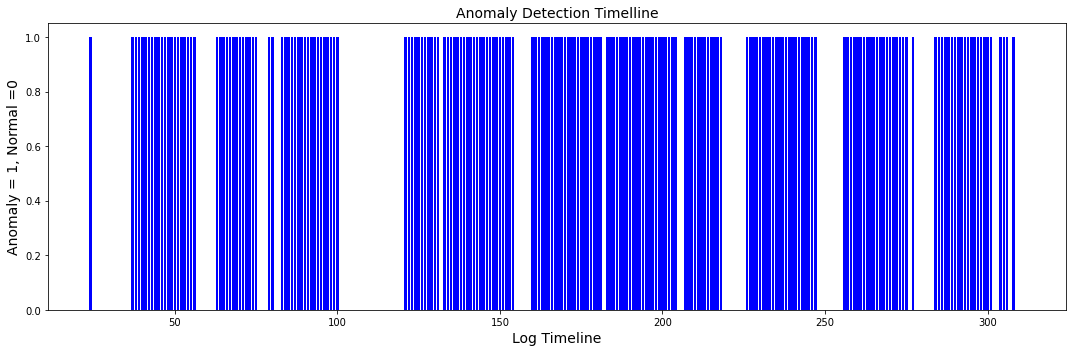

In [8]:
#print backtrack of logs
#tp att are for true positives
#fn att are for false negatives

att, tp_att, fn_att = create_mat(test_abnormal_loader, model, layers, heads, "ntp-ddos", enc=True, dec=False)
